In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-11-16 10:22:36.829246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Necessity

In [3]:
test_results = glob.glob('../results/necessity_test/enformer/*pickle')

In [5]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
tile_coords = pd.read_csv('../old_results//sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [14]:
for _, row in cell_line_context.iterrows():
    res_path = row['path'].replace('context_dependence_test', 'necessity_test')
    res_raw = utils.read_pickle(res_path) 
    res = {k: r[:, :, c].mean(axis=1) for k, r in res_raw.items()}
    if res['mut'].shape[0] == 40:
        print(res_path)
    

../results/necessity_test/enformer/MLLT11_chr1_151060396_+.pickle
../results/necessity_test/enformer/SNURF_chr15_24955013_+.pickle
../results/necessity_test/enformer/PSMG2_chr18_12703041_+.pickle
../results/necessity_test/enformer/DMRTC2_chr19_41845019_+.pickle
../results/necessity_test/enformer/CGRRF1_chr14_54509905_+.pickle
../results/necessity_test/enformer/GALM_chr2_38666116_+.pickle
../results/necessity_test/enformer/LACTB_chr15_63121860_+.pickle
../results/necessity_test/enformer/TNFSF12_chr17_7549062_+.pickle
../results/necessity_test/enformer/CLUAP1_chr16_3501011_+.pickle
../results/necessity_test/enformer/CCDC124_chr19_17933014_+.pickle
../results/necessity_test/enformer/MOGAT1_chr2_222671657_+.pickle
../results/necessity_test/enformer/SH3BP2_chr4_2793084_+.pickle
../results/necessity_test/enformer/TMEM254_chr10_80078645_+.pickle
../results/necessity_test/enformer/SLC24A1_chr15_65611404_+.pickle
../results/necessity_test/enformer/ZNF205_chr16_3112585_+.pickle
../results/necess

In [6]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'necessity_test')
        res_raw = utils.read_pickle(res_path) 
        res = {k: r[:, :, c].mean(axis=1) for k, r in res_raw.items()}
        # res['mut'] = np.delete(res['mut'], 19)
        one_seq = pd.DataFrame((res['wt'] - res['mut']) / res['wt'])
        one_seq.columns = ['Normalized shuffle effect']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3


ValueError: Length of values (38) does not match length of index (40)

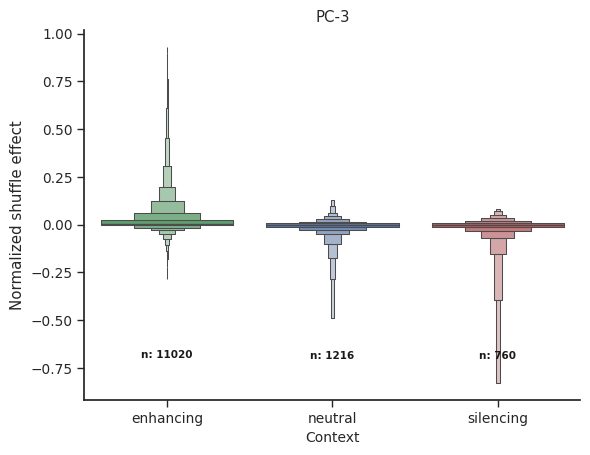

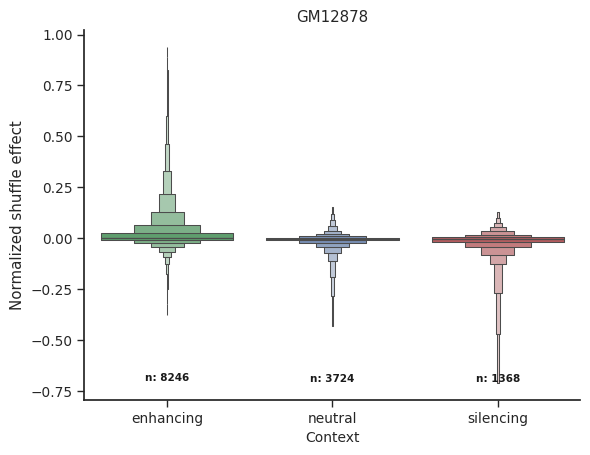

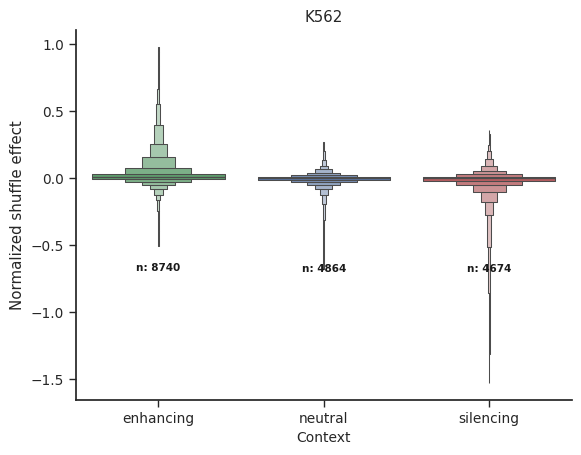

In [21]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for cell, df in result_summary.items():
    ax=sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
                  hue='context',
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)

    # add number of observations in each box
    medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    plt.title(cell)
    plt.show()
    

In [22]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_df = df[df['Normalized shuffle effect'] > 0.3]
    enh_df['tile class'] = 'Enhancer'
    selected_cres.append(enh_df)
    sil_df = df[df['Normalized shuffle effect'] < -0.3]
    sil_df['tile class'] = 'Silencer'
    selected_cres.append(sil_df)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_921612/553665789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_df['tile class'] = 'Enhancer'
/tmp/ipykernel_921612/553665789.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_df['tile class'] = 'Silencer'
/tmp/ipykernel_921612/553665789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [23]:
selected_cres.groupby(['cell_line', 'tile class']).count()

Normalized shuffle effect  seq_id  tile_start  tile_end   
cell_line tile class                                                            
GM12878   Enhancer                          145     145         145       145  \
          Silencer                           46      46          46        46   
K562      Enhancer                          223     223         223       223   
          Silencer                          118     118         118       118   
PC-3      Enhancer                          177     177         177       177   
          Silencer                           27      27          27        27   

                      context  
cell_line tile class           
GM12878   Enhancer        145  
          Silencer         46  
K562      Enhancer        223  
          Silencer        118  
PC-3      Enhancer        177  
          Silencer         27

In [24]:
selected_cres.to_csv('../results/necessity_test/enformer_selected_cres.csv')

# Sufficiency

In [226]:
test_results = glob.glob('../results/sufficiency_test/enformer/*pickle')

In [227]:
track_index = [4824, 5110, 5111]
bin_index = [447, 448]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [228]:
tile_coords = pd.read_csv('../results/sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [229]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'sufficiency_test')
        res = utils.read_pickle(res_path) 
        res['wt'] = res['wt'][bin_index, c].mean(axis=0)
        res['mut'] = res['mut'][:, bin_index, c].mean(axis=1)
        res['control'] = res['control'][:, bin_index, c].mean(axis=1)
        one_seq = pd.DataFrame((res['mut'] - res['control']) / res['wt'])
        one_seq.columns = ['Normalized CRE effect']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3
1 GM12878
2 K562


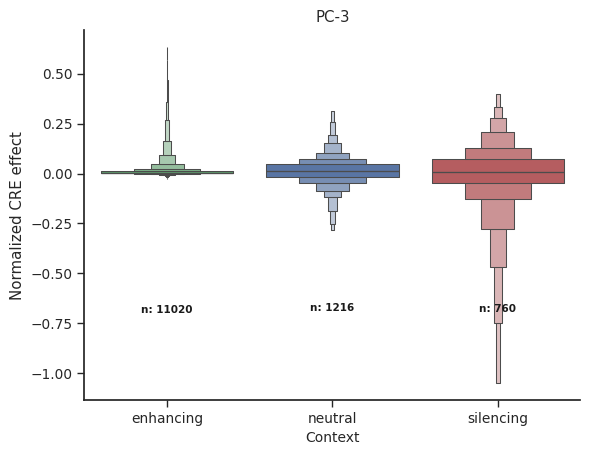

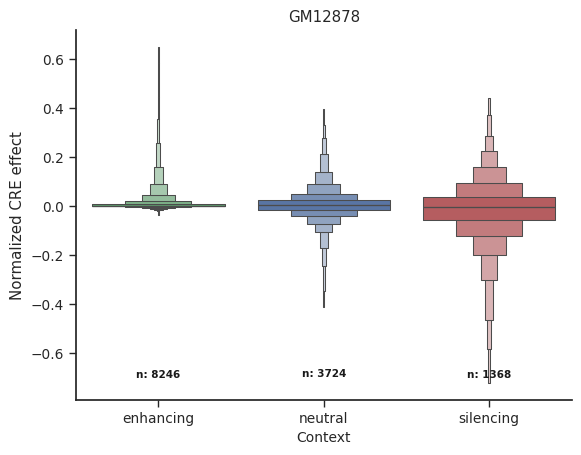

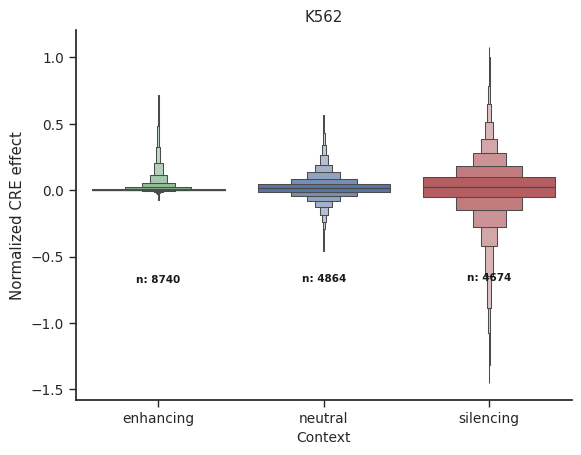

In [230]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for cell, df in result_summary.items():
    ax=sns.boxenplot(x='context', y='Normalized CRE effect', data=df, 
                  showfliers=False,
                  hue='context',
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)
        # add number of observations in each box
    medians = df.groupby(['context'])['Normalized CRE effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    plt.title(cell)
    plt.show()
    

# threshold CREs for distance test

In [237]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_df = df[df['Normalized CRE effect'] > 0.3]
    enh_df['tile class'] = 'Enhancer'
    selected_cres.append(enh_df)
    sil_df = df[df['Normalized CRE effect'] < -0.3]
    sil_df['tile class'] = 'Silencer'
    selected_cres.append(sil_df)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_455058/4254388681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_df['tile class'] = 'Enhancer'
/tmp/ipykernel_455058/4254388681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_df['tile class'] = 'Silencer'
/tmp/ipykernel_455058/4254388681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [238]:
selected_cres.groupby(['cell_line', 'tile class']).count()

Normalized CRE effect  seq_id  tile_start  tile_end   
cell_line tile class                                                        
GM12878   Enhancer                       89      89          89        89  \
          Silencer                       61      61          61        61   
K562      Enhancer                      391     391         391       391   
          Silencer                      282     282         282       282   
PC-3      Enhancer                       93      93          93        93   
          Silencer                       47      47          47        47   

                      context  
cell_line tile class           
GM12878   Enhancer         89  
          Silencer         61  
K562      Enhancer        391  
          Silencer        282  
PC-3      Enhancer         93  
          Silencer         47

In [239]:
selected_cres.to_csv('../results/sufficiency_test/enformer_selected_cres.csv')

<Axes: xlabel='Normalized CRE effect', ylabel='Count'>

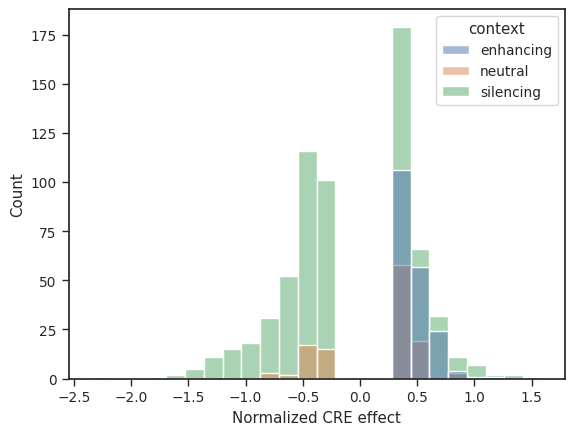

In [217]:
sns.histplot(data=selected_cres, x='Normalized CRE effect', hue='context')

In [214]:
selected_cres

,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line
18,0.643710,SIGMAR1_chr9_34635317_-,90804,95804,enhancing,PC-3
18,0.488182,S100A11_chr1_152032505_-,90804,95804,enhancing,PC-3
20,0.393512,ARHGAP11A_chr15_32615503_+,105804,110804,enhancing,PC-3
19,0.391855,PSMD1_chr2_231056893_+,100804,105804,enhancing,PC-3
19,0.309734,APOBEC3C_chr22_39014256_+,100804,105804,enhancing,PC-3
...,...,...,...,...,...,...
21,-1.153904,ZNF570_chr19_37469355_+,110804,115804,silencing,K562
22,-0.341064,ZNF570_chr19_37469355_+,115804,120804,silencing,K562
19,-0.310034,ENSG00000288000_chr20_43458053_+,100804,105804,silencing,K562
23,-0.861627,ENSG00000267179_chr19_11925110_+,120804,125804,silencing,K562


In [147]:
12996 / 38

342.0